# 1. Setting up the enviroment

In [ ]:
# Install necessary python dependencies
! pip install -r requirements.txt

In [2]:
from pathlib import Path

# Define paths - REMOTE
PROJECT_ROOT = Path.cwd()
data_path = PROJECT_ROOT / 'into-the-multiverse' /'data' / 'abide'
output_path = PROJECT_ROOT / 'into-the-multiverse' / 'output'/ 'abide'

# Change accordingly to where the raw data has been downloaded. The data can be downloaded from
# (http://preprocessed-connectomes-project.org/abide/download.html is downloaded
data_raw = Path('/Volumes/abide')
if not output_path.is_dir():
    output_path.mkdir(parents=True)

In [19]:
Path.cwd()

PosixPath('/Users/jessica/Code/into-the-multiverse-revised')

In [3]:
# To run LOCALLY
import os
os.chdir('/Users/jessica/Code/into-the-multiverse-revised')
import warnings
warnings.filterwarnings("ignore")


# Define paths - LOCALLY
# All paths are expected to be Path objects
PROJECT_ROOT = Path.cwd()
data_root = Path('/Volumes/abide')
output_path = PROJECT_ROOT / 'output' / 'abide'
data_path = PROJECT_ROOT / 'into-the-multiverse' /'data' / 'abide'
data_raw = Path('/Volumes/abide')
if not output_path.is_dir():
    output_path.mkdir(parents=True)

In [4]:
# Define key variables
# Add the into-the-multiverse folder to the Python path. This allows the helperfunction
# to be used
import sys
sys.path.insert(1, 'into-the-multiverse')
import numpy as np
np.random.seed(1234)


In [5]:
from collections import OrderedDict
import pickle
import json
from functools import partial
import os

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from scipy.stats import spearmanr
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import manifold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor

from nilearn.connectome import ConnectivityMeasure
from umap.umap_ import UMAP
import phate

from helperfunctions import (initialize_bo, run_bo, load_abide_demographics, plot_bo_estimated_space, plot_bo_evolution,
                             posteriorOnlyModels, plot_bo_repetions, objective_func_class)

%load_ext autoreload
%autoreload 2


In [6]:
# Define the space variables
derivatives = ['rois_tt', 'rois_ho', 'rois_ez', 'rois_dosenbach160', 'rois_cc400', 'rois_cc200']
pipelines = ['cpac', 'ccs', 'dparsf', 'niak']
strategies = ['filt_global', 'nofilt_global', 'nofilt_noglobal', 'filt_noglobal']
conn_metrics = ['tangent', 'correlation', 'partial correlation', 'covariance']

# 2. Run the different analysis to bild the space

The next step assumes that the data has been downloaded. The data can be downloaded from (http://preprocessed-connectomes-project.org/abide/download.html). For time reasons, we will not download the data within this notebook. To run this script the code expects the files to be in the following structure:

```
├── ccs
│   ├── filt_global
│   ├── filt_noglobal
│   ├── nofilt_global
│   └── nofilt_noglobal
├── cpac
│   ├── filt_global
│   ├── filt_noglobal
│   ├── nofilt_global
│   └── nofilt_noglobal
├── dparsf
│   ├── filt_global
│   ├── filt_noglobal
│   ├── nofilt_global
│   └── nofilt_noglobal
└── niak
    ├── filt_global
    ├── filt_noglobal
    ├── nofilt_global
    └── nofilt_noglobal
```

However, to facilitate reproducibility together with this code. We are providing the file `output/abide/abide_space.pckl`, which contains the output from the next cell. 

In [ ]:
# select the subjects we want to use to create the space (about 20% of the total subjects) making sure that
# both classes are equally represented

# Load data demographics
abide_df = load_abide_demographics(data_root)
indices = np.arange(len(abide_df))
idx_space, idx_train_holdout = train_test_split(indices, test_size=.8, train_size=.2, random_state=0,
                                        shuffle=True, stratify=abide_df['DX_GROUP'])
# Split the training data again, to keep part of the dataset as a hold out dataset

idx_train, idx_holdout = train_test_split(idx_train_holdout, test_size=.25, train_size=.75, random_state=0,
                                          shuffle=True, stratify=abide_df['DX_GROUP'].iloc[idx_train_holdout])
# Visualise stratification
space_df = abide_df.iloc[idx_space]
print('Numbers on space df')
print(space_df['DX_GROUP'].value_counts())

train_df = abide_df.iloc[idx_train]
print('Numbers on training df')
print(train_df['DX_GROUP'].value_counts())

holdout_df = abide_df.iloc[idx_holdout]
print('Numbers on hold out df')
print(holdout_df['DX_GROUP'].value_counts())

# save list of indexes of the data split
indices = {'idx_train': idx_train.tolist(),
           'idx_space': idx_space.tolist(),
           'idx_holdout': idx_holdout.tolist()}
with open((output_path / f'indices_space_train.json'), 'w') as handle:
    json.dump(indices, handle)

The next cell will create the space

In [ ]:
n_idx_space = int(len(idx_space) * (len(idx_space) - 1) / 2)
count = 0
ResultsIndVar = np.zeros(((len(derivatives) * len(pipelines) * len(strategies) * len(conn_metrics)), n_idx_space))
methods_idx = {}
space_rois = {}
with tqdm(range(len(derivatives) * len(pipelines) * len(strategies) * len(conn_metrics))) as pbar:
    for derivative in derivatives:
        space_rois[derivative] = {}
        for pipeline in pipelines:
            space_rois[derivative][pipeline] = {}
            for strategy in strategies:
                space_rois[derivative][pipeline][strategy] = {}
                for conn_metric in conn_metrics:
                    data_path = data_root / 'Outputs' / pipeline / strategy / derivative
                    space_rois[derivative][pipeline][strategy][conn_metric] = []
                    for subject_idx in idx_space:
                        subject = abide_df.iloc[subject_idx]['FILE_ID']
                        subject_path = data_path / f'{subject}_{derivative}.1D'
                        rois = pd.read_csv(subject_path, delimiter='\t')
                        space_rois[derivative][pipeline][strategy][conn_metric].append(rois.to_numpy())
                        methods_idx[count] = [derivative, pipeline, strategy, conn_metric]
                    count += 1
                    pbar.update(1)

count = 0
# Iterate over the possible configurations and calculate the connectivity metric.
with tqdm(range(len(derivatives) * len(pipelines) * len(strategies) * len(conn_metrics))) as pbar:
    for derivative in derivatives:
        for pipeline in pipelines:
            for strategy in strategies:
                for conn_metric in conn_metrics:
                    space_flat_rois = []
                    correlation_measure = ConnectivityMeasure(kind=conn_metric)
                    correlation_matrix = correlation_measure.fit_transform(
                        space_rois[derivative][pipeline][strategy][conn_metric])
                    # Plot the upper diagonal connectivity matrix, excluding the diagonal (k=1)
                    # correlation_matrix = np.triu(correlation_matrix, k=1)
                    # plotting.plot_matrix(correlation_matrix, colorbar=True, vmax=1, vmin=-1)
                    # plt.savefig(output_path / f'{subject}_{derivative}.png')
                    for subject_idx in range(len(idx_space)):
                        tmp = correlation_matrix[subject_idx][np.triu_indices(
                            space_rois[derivative][pipeline][strategy][conn_metric][0].shape[1], k=1)]
                        space_flat_rois.append(tmp)

                    # Build an array of similarities between subjects for each analysis approach. This is used as a
                    # distance metric between the different subjects
                    cos_sim = cosine_similarity(space_flat_rois)
                    ResultsIndVar[count, :] = cos_sim[np.triu_indices(len(idx_space), k=1)]
                    count += 1
                    pbar.update(1)

# Save results
save_results = {'Results': ResultsIndVar, 'methods_idx': methods_idx}
with open((output_path / 'abide_space.pckl'), 'wb') as handle:
    pickle.dump(save_results, handle)

# 3. Building and analysing the low-dimensional space

In [ ]:
# Load the indices we want to use for the analysis
with open((output_path / f'indices_space_train.json'), 'r') as handle:
    indices = json.load(handle)

idx_train = indices['idx_train']
idx_space = indices['idx_space']

train_df = abide_df.iloc[idx_train]
print('Numbers on training df')
print(train_df['DX_GROUP'].value_counts())
space_df = abide_df.iloc[idx_space]
print('Numbers on space df')
print(space_df['DX_GROUP'].value_counts())



In [ ]:
with open((output_path / 'abide_space.pckl'), 'rb') as handle:
    save_results = pickle.load(handle)
ResultsIndVar = save_results['Results']
methods_idx = save_results['methods_idx']

# Reduced dataset
data_reduced = {}

# plot tSNE
Results = ResultsIndVar
scaler = StandardScaler()
X = scaler.fit_transform(Results.T)
X = X.T
n_neighbors = 60
n_components = 2
#Define different dimensionality reduction techniques
methods = OrderedDict()
LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors, n_components, eigen_solver='dense')
methods['LLE'] = LLE(method='standard', random_state=0)
methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
                                           n_neighbors=n_neighbors, random_state=0)
methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',  perplexity=150,
                                 random_state=0)
methods['UMAP'] = UMAP(random_state=40, n_components=2, n_neighbors=200,
                             min_dist=.8)
methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=10,
                              random_state=21, metric=True)
methods['PHATE'] = phate.PHATE()


methods['PCA'] = PCA(n_components=2)

In [ ]:
# Define markers for the derivatives
markers = ['s', 'o', '^', 'D', 'v', '*']
markers_order = np.array([pip[0] for pip in methods_idx.values()])

# Define colors and markers for the pipeliens
#colourmaps = {'ccs': 'Greens', 'cpac': 'Purples', 'dparsf': 'Blues', 'niak': 'Reds'}
colourmaps = {'correlation': 'Greens', 'covariance': 'Purples', 'partial correlation': 'Blues', 'tangent': 'Reds'}
metrics_order = np.array([pip[3] for pip in methods_idx.values()])

# Define colors and markers for the strategies
markers_strategies = {'filt_global': .7, 'nofilt_global': .4, 'nofilt_noglobal': .15, 'filt_noglobal': .55}
strategies_order = [pip[2] for pip in methods_idx.values()]
strategies_int = np.array([markers_strategies[x] for x in strategies_order])

markers_metric = ['-', '/', '.', "x"]
markers_map = {'cpac': '-', 'ccs': '/', 'dparsf': '.', 'niak': 'x'}
pipeline_order = np.array([pip[1] for pip in methods_idx.values()])


In [ ]:
selected_analysis = 'MDS'
Lines = {}
Y = methods[selected_analysis].fit_transform(X)
data_reduced[selected_analysis] = Y
figMDS = plt.figure(figsize=(21, 15))
gsMDS = figMDS.add_gridspec(nrows=15, ncols=20)
axs = figMDS.add_subplot(gsMDS[:, 0:15])
#for idx_pip, pipeline in enumerate(sorted(colourmaps)):
for idx_metric, conn_metric in enumerate(sorted(colourmaps)):
    for idx_pipeline, pipeline in enumerate(sorted(pipelines)):
        for idx_derivative, derivative in enumerate(sorted(derivatives)):
            axs.scatter(Y[:, 0][(markers_order == derivative) & (metrics_order == conn_metric) & (pipeline_order == pipeline)],
                        Y[:, 1][(markers_order == derivative) & (metrics_order == conn_metric) & (pipeline_order == pipeline)],
                        c=strategies_int[(markers_order == derivative) & (metrics_order == conn_metric) & (pipeline_order == pipeline)],
                        s=180, marker=markers[idx_derivative], hatch=4*markers_metric[idx_pipeline],
                        norm=plt.Normalize(vmin=0, vmax=1),
                        cmap=colourmaps[conn_metric])
            Lines[idx_derivative] = mlines.Line2D([], [], color='black', linestyle='None', marker=markers[idx_derivative],
                                              markersize=10, label=derivative)
axs.spines['top'].set_linewidth(1.5)
axs.spines['right'].set_linewidth(1.5)
axs.spines['bottom'].set_linewidth(1.5)
axs.spines['left'].set_linewidth(1.5)
axs.set_xlabel('dimension 2', fontsize=25)
axs.set_ylabel('dimension 1', fontsize=25)
axs.tick_params(labelsize=15)
axs.set_title(f'{selected_analysis}', fontsize=20, fontweight="bold")
plt.axis('tight')
GreenPatch = mpatches.Patch(color='#52b365', label='correlation')
PurplePatch = mpatches.Patch(color='#8a86bf', label='covariance')
BluesPatch = mpatches.Patch(color='#4f9bcb', label='partial correlation')
RedsPatch = mpatches.Patch(color='#f34a36', label='tangent')
IntensityPatch1 = mpatches.Patch(color=[0.1, 0.1, 0.1], label='filter and GSR',
                                 alpha=1)
IntensityPatch2 = mpatches.Patch(color=[0.1, 0.1, 0.1], label='filter and no GSR',
                                 alpha=0.5)
IntensityPatch3 = mpatches.Patch(color=[0.1, 0.1, 0.1], label='no filter and GSR',
                                 alpha=0.2)
IntensityPatch4 = mpatches.Patch(color=[0.1, 0.1, 0.1], label='no filter and no GSR',
                                 alpha=0.1)
line_patchPatch = mpatches.Patch(facecolor=[0.1, 0.1, 0.1], hatch=4*markers_metric[0], label=sorted(pipelines)[0],
                                 alpha=.1)
dot_patchPatch = mpatches.Patch(facecolor=[0.1, 0.1, 0.1], hatch=4*markers_metric[1], label=sorted(pipelines)[1],
                                alpha=.1)
diagonal_patchPatch = mpatches.Patch(facecolor=[0.1, 0.1, 0.1], hatch=4*markers_metric[2], label=sorted(pipelines)[2],
                                     alpha=.1)
x_patchPatch = mpatches.Patch(facecolor=[0.1, 0.1, 0.1], hatch=4*markers_metric[3], label=sorted(pipelines)[3],
                                     alpha=.1)
BlankLine = mlines.Line2D([], [], linestyle='None')

plt.legend(handles=[GreenPatch, BluesPatch, PurplePatch, RedsPatch, BlankLine, IntensityPatch1,
                       IntensityPatch2, IntensityPatch3, IntensityPatch4, BlankLine,
                       Lines[0], Lines[1], Lines[2], Lines[3], Lines[4], Lines[5], BlankLine,
                       line_patchPatch, dot_patchPatch, diagonal_patchPatch, x_patchPatch
                     ],
           fontsize=24, frameon=False, bbox_to_anchor=(1.4, .97), bbox_transform=axs.transAxes)
plt.savefig(output_path / f'{selected_analysis}_v2.png',  dpi=300)
plt.savefig(output_path / f'{selected_analysis}_v2.svg', format='svg')

In [ ]:
# Plot the other methods
# Reduced dimensions
# As we already analysed the MDS drop it from the dictionary
methods.pop(selected_analysis)
gsDE, axs = plt.subplots(3, 2, figsize=(16, 16), constrained_layout=True)
axs = axs.ravel()
for idx_method, (label, method) in enumerate(methods.items()):
    Y = method.fit_transform(X)
    # Save the results
    data_reduced[label] = Y
    Lines = {}

    # for idx_pip, pipeline in enumerate(sorted(colourmaps)):
    for idx_metric, conn_metric in enumerate(sorted(colourmaps)):
        for idx_pipeline, pipeline in enumerate(sorted(pipelines)):
            for idx_derivative, derivative in enumerate(sorted(derivatives)):
                axs[idx_method].scatter(Y[:, 0][(markers_order == derivative) & (metrics_order == conn_metric) & (
                            pipeline_order == pipeline)],
                            Y[:, 1][(markers_order == derivative) & (metrics_order == conn_metric) & (
                                        pipeline_order == pipeline)],
                            c=strategies_int[(markers_order == derivative) & (metrics_order == conn_metric) & (
                                        pipeline_order == pipeline)],
                            s=180, marker=markers[idx_derivative], hatch=4 * markers_metric[idx_pipeline],
                            norm=plt.Normalize(vmin=0, vmax=1),
                            cmap=colourmaps[conn_metric])
                Lines[idx_derivative] = mlines.Line2D([], [], color='black', linestyle='None',
                                                      marker=markers[idx_derivative],
                                                      markersize=10, label=derivative)
    if idx_method %2 == 0:
        axs[idx_method].set_xlabel('Dimension 1', fontsize=20)
    if (idx_method == 4) or (idx_method == 5):
        axs[idx_method].set_ylabel('Dimension 2', fontsize=20)

    axs[idx_method].set_title(f'{label}', fontsize=20, fontweight="bold")
    axs[idx_method].axis('tight')
    axs[idx_method].tick_params(labelsize=15)

GreenPatch = mpatches.Patch(color='#52b365', label='correlation')
PurplePatch = mpatches.Patch(color='#8a86bf', label='covariance')
BluesPatch = mpatches.Patch(color='#4f9bcb', label='partial correlation')
RedsPatch = mpatches.Patch(color='#f34a36', label='tangent')
IntensityPatch1 = mpatches.Patch(color=[0.1, 0.1, 0.1], label='filter and GSR',
                                 alpha=1)
IntensityPatch2 = mpatches.Patch(color=[0.1, 0.1, 0.1], label='filter and no GSR',
                                 alpha=0.5)
IntensityPatch3 = mpatches.Patch(color=[0.1, 0.1, 0.1], label='no filter and GSR',
                                 alpha=0.2)
IntensityPatch4 = mpatches.Patch(color=[0.1, 0.1, 0.1], label='no filter and no GSR',
                                 alpha=0.1)
line_patchPatch = mpatches.Patch(facecolor=[0.1, 0.1, 0.1], hatch=4 * markers_metric[0], label=sorted(pipelines)[0],
                                 alpha=.1)
dot_patchPatch = mpatches.Patch(facecolor=[0.1, 0.1, 0.1], hatch=4 * markers_metric[1], label=sorted(pipelines)[1],
                                alpha=.1)
diagonal_patchPatch = mpatches.Patch(facecolor=[0.1, 0.1, 0.1], hatch=4 * markers_metric[2],
                                     label=sorted(pipelines)[2],
                                     alpha=.1)
x_patchPatch = mpatches.Patch(facecolor=[0.1, 0.1, 0.1], hatch=4 * markers_metric[3], label=sorted(pipelines)[3],
                              alpha=.1)
BlankLine = mlines.Line2D([], [], linestyle='None')

gsDE.legend(handles=[GreenPatch, BluesPatch, PurplePatch, RedsPatch, BlankLine, IntensityPatch1,
                    IntensityPatch2, IntensityPatch3, IntensityPatch4, BlankLine,
                    Lines[0], Lines[1], Lines[2], Lines[3], Lines[4], Lines[5], BlankLine,
                    line_patchPatch, dot_patchPatch, diagonal_patchPatch, x_patchPatch],
           fontsize=15, frameon=False, bbox_to_anchor=(1.25, 0.7))

gsDE.savefig(str(output_path / 'dim_reduction.png'), dpi=300)
gsDE.savefig(str(output_path / 'dim_reduction.svg'), format='svg')


In [ ]:
gsDE.savefig(str(output_path / 'dim_reduction.png'), dpi=300, bbox_inches='tight')
gsDE.savefig(str(output_path / 'dim_reduction.svg'), format='svg', bbox_inches='tight')

In [ ]:
# save embeddings
with open((output_path / 'embeddings.pckl'), 'wb') as handle:
    pickle.dump(data_reduced, handle)

# 4. Exhaustive Search

As in step 1. this step also assumes that the data has been previously downloaded. If for computational purposes you do not want to download the data and re-calculate the predictions, we provide the exhaustively search spaced: `output/abide/predictedAcc.pckl`

Note: This is also a time consuming step and might take about 28hrs to complete

In [7]:
# Load the embedding results
with open((output_path / 'embeddings.pckl'), 'rb') as handle:
    embeddings = pickle.load(handle)
# Load the labels for the analysis
with open(output_path / 'abide_space.pckl', 'rb') as handle:
    Data_Run = pickle.load(handle)
# Load indices of the subjects used for train and test
with open((output_path / f'indices_space_train.json'), 'rb') as handle:
    indices = json.load(handle)

In [ ]:
# We will use the MDS space
model_embedding = embeddings['MDS']

abide_df = load_abide_demographics(data_root)
# Select only models to train on
train_df = abide_df.iloc[indices['idx_train']]
train_labels = train_df['DX_GROUP']
files_id = train_df['FILE_ID']

PredictedAcc = np.zeros((len(Data_Run['Results'])))
for count in tqdm(range(len(Data_Run['Results']))):
    PredictedAcc[count] = objective_func_class(Data_Run['methods_idx'], count, train_labels, files_id,
                                                   data_raw, output_path)

# Dump predictions
pickle.dump(PredictedAcc, open(str(output_path / 'predictedAcc.pckl'), 'wb'))



In [ ]:
plt.figure()
plt.scatter(model_embedding[0: PredictedAcc.shape[0], 0],
            model_embedding[0: PredictedAcc.shape[0], 1],
            c=(PredictedAcc), cmap='bwr')
plt.colorbar()
plt.savefig(output_path / 'Predictions.png')

# 5. Active Learning

Note: This step also requires the user to previously downalod the raw data. Due to computation limitations with colab, we are only providing the active learning without repetitions.

In [8]:
def compute_active_learning(kappa, model_config, CassOrRegression):
    # Load data demographics
    abide_df = load_abide_demographics(data_root)

    # Load the embedding results
    with open((output_path / 'embeddings.pckl'), 'rb') as handle:
        embeddings = pickle.load(handle)
    with open(output_path / 'abide_space.pckl', 'rb') as handle:
        Data_Run = pickle.load(handle)
    with open((output_path / 'predictedAcc.pckl'), 'rb') as handle:
        PredictedAcc = pickle.load(handle)
    model_embedding = embeddings['MDS']
    # Load indices of the subjects used for train and test
    with open((output_path / f'indices_space_train.json'), 'rb') as handle:
        indices = json.load(handle)
    # Remove subjects that were used to create the space
    train_df = abide_df.iloc[indices['idx_train']]
    Y = train_df['DX_GROUP']
    files_id = train_df['FILE_ID']

    # Check range of predictions
    PredictedAcc = pickle.load(open(str(output_path / "predictedAcc.pckl"), "rb"))
    print(f'Max {np.max(PredictedAcc)}')
    print(f'Min {np.min(PredictedAcc)}')
    print(f'Mean and std {np.mean(PredictedAcc)} and {np.std(PredictedAcc)}')

    model_config['Data_Run'] = Data_Run['methods_idx']
    model_config['files_id'] = train_df['FILE_ID']
    model_config['output_path'] = output_path

    kernel, optimizer, utility, init_points, n_iter, pbounds, nbrs, RandomSeed = \
        initialize_bo(model_embedding, kappa)

    BadIter = run_bo(optimizer, utility, init_points, n_iter,
           pbounds, nbrs, RandomSeed, model_embedding, model_config,
           Y, ClassOrRegression, MultivariateUnivariate=True,
           repetitions=False, verbose=True)

    x_exploratory, y_exploratory, z_exploratory, x, y, gp, vmax, vmin = \
        plot_bo_estimated_space(kappa, BadIter, optimizer, pbounds, model_embedding, PredictedAcc, kernel,
                                output_path, ClassOrRegression)

    corr = plot_bo_evolution(kappa, x_exploratory, y_exploratory, z_exploratory, x, y, gp,
                             vmax, vmin, model_embedding, PredictedAcc, output_path, ClassOrRegression)

    return corr
    

  0%|                                                                                                                                                                                | 0/60 [00:00<?, ?it/s]

Max 0.7415321304210193
Min 0.4303577081354859
Mean and std 0.6238722697056029 and 0.061795118764971874
Next point to probe is: {'b1': 111.34865718920449, 'b2': 24.14804686414564}


  2%|██▊                                                                                                                                                                     | 1/60 [00:14<14:26, 14.68s/it]

Next Iteration
0
Print indices: 63  59
5.066895305340352
Target Function: 0.5339
 
Next point to probe is: {'b1': 87.06722992894635, 'b2': 2.3249631199511214}


  3%|█████▌                                                                                                                                                                  | 2/60 [00:34<17:06, 17.71s/it]

Next Iteration
1
Print indices: 255  251
10.304756087901499
Target Function: 0.5237
 
Next point to probe is: {'b1': 43.55680897742553, 'b2': 6.3852777736827875}


  5%|████████▍                                                                                                                                                               | 3/60 [00:53<17:31, 18.45s/it]

Next Iteration
2
Print indices: 37  165
1.470038155842364
Target Function: 0.6008
 
Next point to probe is: {'b1': -101.5626252493255, 'b2': -74.72422281724579}


  7%|███████████▏                                                                                                                                                            | 4/60 [01:13<17:32, 18.79s/it]

Next Iteration
3
Print indices: 238  78
8.34165520272447
Target Function: 0.5660
 
Next point to probe is: {'b1': -89.8682891487723, 'b2': 57.18117180900498}


  8%|██████████████                                                                                                                                                          | 5/60 [01:26<15:30, 16.92s/it]

Next Iteration
4
Print indices: 51  53
10.41079050731741
Target Function: 0.5152
 
Next point to probe is: {'b1': 48.298375110382636, 'b2': -54.4940993569912}


 10%|████████████████▊                                                                                                                                                       | 6/60 [01:47<16:17, 18.10s/it]

Next Iteration
5
Print indices: 217  219
18.049143115765013
Target Function: 0.6709
 
Next point to probe is: {'b1': -102.91129148538064, 'b2': 68.79273980144919}


 12%|███████████████████▌                                                                                                                                                    | 7/60 [02:01<14:58, 16.95s/it]

Next Iteration
6
Print indices: 53  51
9.359614220212967
Target Function: 0.5948
 
Next point to probe is: {'b1': -0.2971433902063154, 'b2': -115.85369852078377}


 13%|██████████████████████▍                                                                                                                                                 | 8/60 [02:23<15:55, 18.38s/it]

Next Iteration
7
Print indices: 371  307
4.287853824425301
Target Function: 0.4402
 
Next point to probe is: {'b1': -103.13994290243313, 'b2': -96.90074685535086}


 15%|█████████████████████████▏                                                                                                                                              | 9/60 [02:42<15:51, 18.66s/it]

Next Iteration
8
Print indices: 238  206
14.094275164571938
Target Function: 0.5660
 
Next point to probe is: {'b1': 4.0842449178375375, 'b2': -120.56895478108723}


 17%|███████████████████████████▊                                                                                                                                           | 10/60 [03:02<16:01, 19.22s/it]

Next Iteration
9
Print indices: 371  307
2.1717557544690598
Target Function: 0.4402
 
Next point to probe is: {'b1': 108.82641305392343, 'b2': -89.93650918246303}
Next Iteration
10
18.486380181366854
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': 25.029659782576747, 'b2': -43.2642658552626}
Next Iteration
11
10.896926201553326
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': 79.3996714922315, 'b2': -39.09256678152566}


 18%|██████████████████████████████▌                                                                                                                                        | 11/60 [03:18<14:41, 17.99s/it]

Next Iteration
12
Print indices: 31  155
1.4987822949001852
Target Function: 0.6532
 
Next point to probe is: {'b1': -128.26703986456715, 'b2': 111.49280087469008}
Next Iteration
13
43.64776118078295
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': 33.81360355537888, 'b2': 52.30703539057188}
Next Iteration
14
25.549466758018145
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': 123.47552108221993, 'b2': -33.11801643413452}


 20%|█████████████████████████████████▍                                                                                                                                     | 12/60 [03:33<13:52, 17.35s/it]

Next Iteration
15
Print indices: 45  105
4.276952871502422
Target Function: 0.6689
 
Next point to probe is: {'b1': -130.07579489416412, 'b2': -29.162195533919835}


 22%|████████████████████████████████████▏                                                                                                                                  | 13/60 [03:54<14:15, 18.20s/it]

Next Iteration
16
Print indices: 234  174
5.2962605342473115
Target Function: 0.5554
 
Next point to probe is: {'b1': -130.07579489416412, 'b2': 36.76494499914544}
Next Iteration
17
15.071571048475668
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': -56.57187498554419, 'b2': 116.99544261424327}


 23%|██████████████████████████████████████▉                                                                                                                                | 14/60 [04:38<20:05, 26.20s/it]

Next Iteration
18
Print indices: 252  228
5.849874309119603
Target Function: 0.5639
 
Next point to probe is: {'b1': -6.661181505007845, 'b2': 137.1093514485301}


 25%|█████████████████████████████████████████▊                                                                                                                             | 15/60 [05:25<24:10, 32.23s/it]

Next Iteration
19
Print indices: 200  196
0.6411353182711093
Target Function: 0.6228
 
Next point to probe is: {'b1': 39.07900780244, 'b2': 135.9034761822274}


 27%|████████████████████████████████████████████▌                                                                                                                          | 16/60 [06:14<27:30, 37.51s/it]

Next Iteration
20
Print indices: 216  248
7.902590554806083
Target Function: 0.6477
 
Next point to probe is: {'b1': 80.45079121125436, 'b2': 137.1093514485301}
Next Iteration
21
29.194810636828425
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': 7.088277860494703, 'b2': 100.51708338262996}


 28%|███████████████████████████████████████████████▎                                                                                                                       | 17/60 [06:44<25:06, 35.04s/it]

Next Iteration
22
Print indices: 188  184
2.0503724966998114
Target Function: 0.6337
 
Next point to probe is: {'b1': -62.06678356067602, 'b2': -27.56943169941375}


 30%|██████████████████████████████████████████████████                                                                                                                     | 18/60 [06:59<20:27, 29.23s/it]

Next Iteration
23
Print indices: 150  146
2.8926462617909725
Target Function: 0.5980
 
Next point to probe is: {'b1': -27.653264051899693, 'b2': 11.121330355095395}
Next Iteration
24
11.12157763120808
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': -77.22407120574672, 'b2': -131.09308006910916}
Next Iteration
25
43.09429076285203
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': 126.036282557514, 'b2': 79.87929266004294}
Next Iteration
26
18.30960364260253
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': -44.078648873706754, 'b2': -70.9801757732603}


 32%|████████████████████████████████████████████████████▉                                                                                                                  | 19/60 [07:19<18:03, 26.44s/it]

Next Iteration
27
Print indices: 197  193
4.045802382223379
Target Function: 0.6258
 
Next point to probe is: {'b1': 58.141418869903475, 'b2': -109.35775349934353}


 33%|███████████████████████████████████████████████████████▋                                                                                                               | 20/60 [07:32<14:52, 22.32s/it]

Next Iteration
28
Print indices: 73  329
2.069776934110494
Target Function: 0.7398
 
Next point to probe is: {'b1': 80.61256820496476, 'b2': -130.78272176730772}
Next Iteration
29
28.352727390715643
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': 34.63132313769438, 'b2': -86.53558763053806}
Next Iteration
30
16.358104992076758
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': 72.9053133176786, 'b2': -90.71222261019035}


 35%|██████████████████████████████████████████████████████████▍                                                                                                            | 21/60 [07:50<13:43, 21.11s/it]

Next Iteration
31
Print indices: 143  271
5.228467262756433
Target Function: 0.6447
 
Next point to probe is: {'b1': -23.85359805168386, 'b2': 85.50983027537006}


 37%|█████████████████████████████████████████████████████████████▏                                                                                                         | 22/60 [09:26<27:29, 43.40s/it]

Next Iteration
32
Print indices: 352  292
1.2758369511100327
Target Function: 0.6914
 
Next point to probe is: {'b1': -13.700186365154803, 'b2': 56.972531921072274}
Next Iteration
33
11.478238897195475
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': -24.02376971739136, 'b2': 113.33831066093742}


 38%|██████████████████████████████████████████████████████████████▊                                                                                                     | 23/60 [16:20<1:35:29, 154.86s/it]

Next Iteration
34
Print indices: 256  260
3.6878613511954708
Target Function: 0.7089
 
Next point to probe is: {'b1': -129.7759642723793, 'b2': -129.89174741886825}
Next Iteration
35
55.160854013101535
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': -87.86959939199947, 'b2': 1.4321623513758368}


 40%|█████████████████████████████████████████████████████████████████▌                                                                                                  | 24/60 [16:47<1:09:50, 116.40s/it]

Next Iteration
36
Print indices: 354  158
1.897407477594818
Target Function: 0.6646
 
Next point to probe is: {'b1': 59.46352126956518, 'b2': 93.81143605329399}


 42%|█████████████████████████████████████████████████████████████████████▌                                                                                                 | 25/60 [17:25<54:06, 92.76s/it]

Next Iteration
37
Print indices: 80  44
8.335156704985883
Target Function: 0.6725
 
Next point to probe is: {'b1': 78.79152458880567, 'b2': 69.99428158888361}


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                              | 26/60 [18:03<43:13, 76.27s/it]

Next Iteration
38
Print indices: 305  243
4.928474684743924
Target Function: 0.6117
 
Next point to probe is: {'b1': -91.09525651042253, 'b2': -41.05388715332581}


 45%|███████████████████████████████████████████████████████████████████████████▏                                                                                           | 27/60 [18:22<32:36, 59.28s/it]

Next Iteration
39
Print indices: 230  102
8.984155603350926
Target Function: 0.5611
 
Next point to probe is: {'b1': -23.621556020167745, 'b2': -45.739200578986186}


 47%|█████████████████████████████████████████████████████████████████████████████▉                                                                                         | 28/60 [18:40<25:01, 46.94s/it]

Next Iteration
40
Print indices: 209  225
3.416919331728085
Target Function: 0.6187
 
Next point to probe is: {'b1': 125.17147851503458, 'b2': 134.5351621973025}
Next Iteration
41
57.99539967708139
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': -89.33081055178775, 'b2': 137.1093514485301}
Next Iteration
42
30.30527633732653
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': -130.07579489416412, 'b2': -64.55416473992564}
Next Iteration
43
20.42226979421785
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': 125.97135905776611, 'b2': -5.922721479977795}


 48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 29/60 [18:58<19:43, 38.19s/it]

Next Iteration
44
Print indices: 107  121
9.96006319439951
Target Function: 0.5009
 
Next point to probe is: {'b1': 38.673675727948876, 'b2': -130.74277714381188}
Next Iteration
45
18.64028964381423
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': -39.34382390464782, 'b2': -109.26746554876425}


 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 30/60 [19:17<16:08, 32.29s/it]

Next Iteration
46
Print indices: 241  16
3.595747357268626
Target Function: 0.5541
 
Next point to probe is: {'b1': 126.036282557514, 'b2': -131.29519888791816}
Next Iteration
47
62.6210695621544
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': -66.05030331663937, 'b2': 24.74124050283533}
Next Iteration
48
22.33213126469159
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': 84.14570715730639, 'b2': 98.6891524853742}
Next Iteration
49
18.055605180388888
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': -12.152919432091542, 'b2': -74.95310500586207}


 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 31/60 [19:54<16:18, 33.74s/it]

Next Iteration
50
Print indices: 261  257
3.1161494705680997
Target Function: 0.7164
 
Next point to probe is: {'b1': 68.98351982893514, 'b2': 33.4131807064664}


 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                              | 32/60 [20:10<13:13, 28.36s/it]

Next Iteration
51
Print indices: 99  163
5.048110194420262
Target Function: 0.5203
 
Next point to probe is: {'b1': 98.74362014872696, 'b2': -57.827732322694246}


 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 33/60 [20:33<12:05, 26.87s/it]

Next Iteration
52
Print indices: 235  93
3.778972062787171
Target Function: 0.5329
 
Next point to probe is: {'b1': -41.228896826467555, 'b2': 137.1093514485301}
Next Iteration
53
14.156165194257877
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': -51.776882849032255, 'b2': 80.38292687244883}


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 34/60 [22:35<24:04, 55.55s/it]

Next Iteration
54
Print indices: 364  272
2.897222140738224
Target Function: 0.7051
 
Next point to probe is: {'b1': 10.027668052701038, 'b2': -3.1016704804778716}


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 35/60 [23:16<21:17, 51.10s/it]

Next Iteration
55
Print indices: 293  279
2.818497492753096
Target Function: 0.6741
 
Next point to probe is: {'b1': 58.65196909475014, 'b2': -21.215808778935468}
Next Iteration
56
12.350908324581656
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': 14.507037418366792, 'b2': 20.266767216272058}


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 36/60 [23:30<15:54, 39.79s/it]

Next Iteration
57
Print indices: 135  23
4.629567963486742
Target Function: 0.6333
 
Next point to probe is: {'b1': -114.06071893579153, 'b2': 3.789393376462122}


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 37/60 [23:45<12:26, 32.47s/it]

Next Iteration
58
Print indices: 178  182
1.3011032381800172
Target Function: 0.5608
 
Next point to probe is: {'b1': -129.1711572935595, 'b2': 75.26686543096429}
Next Iteration
59
33.6999419882673
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': -67.83234488034012, 'b2': -95.64886491548353}


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 38/60 [23:58<09:48, 26.75s/it]

Next Iteration
60
Print indices: 2  322
8.614672994469684
Target Function: 0.5951
 
Next point to probe is: {'b1': -93.54996110459726, 'b2': -22.333173042916314}


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 39/60 [24:15<08:20, 23.84s/it]

Next Iteration
61
Print indices: 90  342
3.3540920860939893
Target Function: 0.6250
 
Next point to probe is: {'b1': -86.30837030146628, 'b2': 100.28942679684326}


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 40/60 [25:18<11:51, 35.60s/it]

Next Iteration
62
Print indices: 224  220
7.130297142325575
Target Function: 0.6211
 
Next point to probe is: {'b1': -63.76963615620308, 'b2': -55.809779979223975}


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 41/60 [25:27<08:43, 27.57s/it]

Next Iteration
63
Print indices: 134  338
5.98487455945708
Target Function: 0.6393
 
Next point to probe is: {'b1': 125.305997549594, 'b2': 44.941879946212964}
Next Iteration
64
12.173942918041199
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': 27.502441032581025, 'b2': 83.30530695002876}


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 42/60 [25:57<08:30, 28.36s/it]

Next Iteration
65
Print indices: 36  40
3.826849559384342
Target Function: 0.6448
 
Next point to probe is: {'b1': -45.90953471683642, 'b2': 55.602263665410646}
Next Iteration
66
16.987567853548605
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': -15.298049407258, 'b2': -17.1581841090508}


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 43/60 [26:18<07:24, 26.14s/it]

Next Iteration
67
Print indices: 231  3
2.1740782718158345
Target Function: 0.5516
 
Next point to probe is: {'b1': -40.54656708673511, 'b2': -131.08958988709512}
Next Iteration
68
20.91447103640026
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': -129.9491805452903, 'b2': 136.58835545150333}
Next Iteration
69
59.09405654756065
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': -98.0348203260836, 'b2': 31.550140140084153}


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 44/60 [26:40<06:35, 24.74s/it]

Next Iteration
70
Print indices: 222  54
3.7697072579032853
Target Function: 0.6287
 
Next point to probe is: {'b1': -129.39461463658714, 'b2': -97.58239259211567}
Next Iteration
71
32.1840938926264
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': 17.346715729475918, 'b2': 137.1093514485301}
Next Iteration
72
16.734856218014354
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': 56.58894253391554, 'b2': 70.78170450415098}
Next Iteration
73
16.788360559620685
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': 98.79445044575812, 'b2': -23.245693162112588}


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 45/60 [26:59<05:44, 22.96s/it]

Next Iteration
74
Print indices: 43  91
8.496406334484073
Target Function: 0.5491
 
Next point to probe is: {'b1': 58.32718718971, 'b2': 117.97682419804843}


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 46/60 [27:48<07:11, 30.86s/it]

Next Iteration
75
Print indices: 212  208
2.655700586687124
Target Function: 0.6380
 
Next point to probe is: {'b1': 125.93912140334788, 'b2': -65.74375205310479}
Next Iteration
76
14.898157557712649
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': -13.530079097140074, 'b2': -92.92918703891179}


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 47/60 [28:04<05:44, 26.50s/it]

Next Iteration
77
Print indices: 35  39
8.510210403676188
Target Function: 0.5204
 
Next point to probe is: {'b1': 32.66741788159274, 'b2': 107.08367388453777}


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 48/60 [28:32<05:23, 26.94s/it]

Next Iteration
78
Print indices: 124  120
1.2879166311334889
Target Function: 0.6589
 
Next point to probe is: {'b1': -0.5090384505330405, 'b2': -52.42200469225256}
Next Iteration
79
11.77479698123933
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': -44.592276703111935, 'b2': -47.37644783354753}


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 49/60 [28:50<04:24, 24.06s/it]

Next Iteration
80
Print indices: 22  213
7.460563178362631
Target Function: 0.6195
 
Next point to probe is: {'b1': 0.833027982599873, 'b2': 80.99167763473136}


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 50/60 [29:33<05:54, 35.48s/it]

Next Iteration
81
Print indices: 100  164
2.775590856268272
Target Function: 0.6792
 


Spearman correlation SpearmanrResult(correlation=0.5543254588063927, pvalue=2.577894076162529e-32)


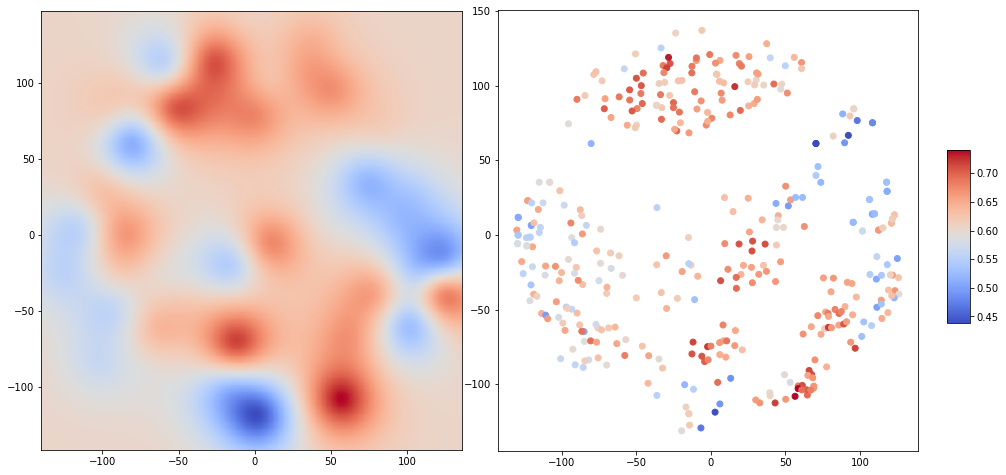

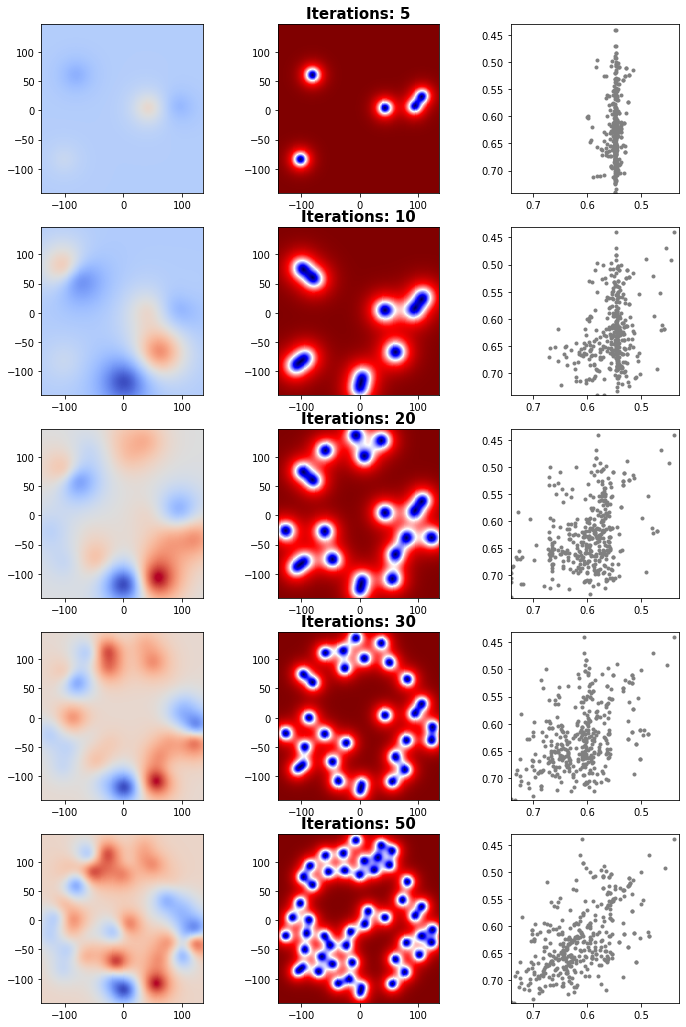

In [9]:
kappa = 10.0
# path to the raw data
model_config = {}
model_config['data_root'] = data_raw
ClassOrRegression = 'Classification'
corr = compute_active_learning(kappa, model_config, ClassOrRegression)
print(f'Spearman correlation {corr}')

  0%|                                                                                                                                                                                | 0/60 [00:00<?, ?it/s]

Max 0.7415321304210193
Min 0.4303577081354859
Mean and std 0.6238722697056029 and 0.061795118764971874
Next point to probe is: {'b1': 111.34865718920449, 'b2': 24.14804686414564}


  2%|██▊                                                                                                                                                                     | 1/60 [00:14<14:11, 14.42s/it]

Next Iteration
0
Print indices: 63  59
5.066895305340352
Target Function: 0.5339
 
Next point to probe is: {'b1': 87.06722992894635, 'b2': 2.3249631199511214}


  3%|█████▌                                                                                                                                                                  | 2/60 [00:32<15:54, 16.46s/it]

Next Iteration
1
Print indices: 255  251
10.304756087901499
Target Function: 0.5237
 
Next point to probe is: {'b1': 43.55680897742553, 'b2': 6.3852777736827875}


  5%|████████▍                                                                                                                                                               | 3/60 [00:46<14:37, 15.40s/it]

Next Iteration
2
Print indices: 37  165
1.470038155842364
Target Function: 0.6008
 
Next point to probe is: {'b1': -101.5626252493255, 'b2': -74.72422281724579}


  7%|███████████▏                                                                                                                                                            | 4/60 [01:05<15:32, 16.65s/it]

Next Iteration
3
Print indices: 238  78
8.34165520272447
Target Function: 0.5660
 
Next point to probe is: {'b1': -89.8682891487723, 'b2': 57.18117180900498}


  8%|██████████████                                                                                                                                                          | 5/60 [01:17<14:01, 15.30s/it]

Next Iteration
4
Print indices: 51  53
10.41079050731741
Target Function: 0.5152
 
Next point to probe is: {'b1': 48.298375110382636, 'b2': -54.4940993569912}


 10%|████████████████▊                                                                                                                                                       | 6/60 [01:35<14:35, 16.21s/it]

Next Iteration
5
Print indices: 217  219
18.049143115765013
Target Function: 0.6709
 
Next point to probe is: {'b1': -102.91129148538064, 'b2': 68.79273980144919}


 12%|███████████████████▌                                                                                                                                                    | 7/60 [01:48<13:21, 15.13s/it]

Next Iteration
6
Print indices: 53  51
9.359614220212967
Target Function: 0.5948
 
Next point to probe is: {'b1': -0.2971433902063154, 'b2': -115.85369852078377}


 13%|██████████████████████▍                                                                                                                                                 | 8/60 [02:08<14:19, 16.53s/it]

Next Iteration
7
Print indices: 371  307
4.287853824425301
Target Function: 0.4402
 
Next point to probe is: {'b1': -103.13994290243313, 'b2': -96.90074685535086}


 15%|█████████████████████████▏                                                                                                                                              | 9/60 [02:29<15:18, 18.01s/it]

Next Iteration
8
Print indices: 238  206
14.094275164571938
Target Function: 0.5660
 
Next point to probe is: {'b1': 4.0842449178375375, 'b2': -120.56895478108723}


 17%|███████████████████████████▊                                                                                                                                           | 10/60 [02:50<15:46, 18.94s/it]

Next Iteration
9
Print indices: 371  307
2.1717557544690598
Target Function: 0.4402
 
Next point to probe is: {'b1': 62.53474175174135, 'b2': -64.19280561908545}


 18%|██████████████████████████████▌                                                                                                                                        | 11/60 [03:12<16:07, 19.75s/it]

Next Iteration
10
Print indices: 217  219
2.3722304875269944
Target Function: 0.6709
 
Next point to probe is: {'b1': 64.07057257951084, 'b2': -64.973660683366}


 20%|█████████████████████████████████▍                                                                                                                                     | 12/60 [03:34<16:21, 20.45s/it]

Next Iteration
11
Print indices: 217  219
4.692472570067139
Target Function: 0.6543
 
Next point to probe is: {'b1': 57.10637889316445, 'b2': -69.18130267146888}


 22%|████████████████████████████████████▏                                                                                                                                  | 13/60 [03:52<15:32, 19.85s/it]

Next Iteration
12
Print indices: 217  219
5.442894948456838
Target Function: 0.6709
 
Next point to probe is: {'b1': 57.147844465705354, 'b2': -69.73540201122077}
Next Iteration
13
13.026213458219825
Target Function Default Bad: 0.4402
 
Next point to probe is: {'b1': 64.67337225502416, 'b2': -65.73405319375607}


 23%|██████████████████████████████████████▉                                                                                                                                | 14/60 [04:35<20:31, 26.78s/it]

Next Iteration
14
Print indices: 217  219
2.9461154812715624
Target Function: 0.6709
 
Next point to probe is: {'b1': 64.37976754558426, 'b2': -65.11672753907331}


 25%|█████████████████████████████████████████▊                                                                                                                             | 15/60 [04:56<18:52, 25.16s/it]

Next Iteration
15
Print indices: 217  219
4.5962287704595965
Target Function: 0.6543
 
Next point to probe is: {'b1': 64.34740419014042, 'b2': -65.78608828406634}


 27%|████████████████████████████████████████████▌                                                                                                                          | 16/60 [05:10<15:58, 21.78s/it]

Next Iteration
16
Print indices: 217  219
2.617473663102992
Target Function: 0.6709
 
Next point to probe is: {'b1': 61.94940283830516, 'b2': -65.6577268644664}


 28%|███████████████████████████████████████████████▎                                                                                                                       | 17/60 [05:21<13:18, 18.57s/it]

Next Iteration
17
Print indices: 217  219
6.730668104534348
Target Function: 0.6543
 
Next point to probe is: {'b1': 61.54335803940245, 'b2': -66.14103026096417}


 30%|██████████████████████████████████████████████████                                                                                                                     | 18/60 [05:35<11:58, 17.10s/it]

Next Iteration
18
Print indices: 217  219
0.4151675517297947
Target Function: 0.6709
 
Next point to probe is: {'b1': 61.851539834263114, 'b2': -66.06464789370582}


 32%|████████████████████████████████████████████████████▉                                                                                                                  | 19/60 [05:46<10:24, 15.23s/it]

Next Iteration
19
Print indices: 217  219
7.0611608664599395
Target Function: 0.6543
 
Next point to probe is: {'b1': 61.5538480077295, 'b2': -64.88873097461372}


 33%|███████████████████████████████████████████████████████▋                                                                                                               | 20/60 [05:57<09:23, 14.09s/it]

Next Iteration
20
Print indices: 217  219
1.5868487958638113
Target Function: 0.6709
 
Next point to probe is: {'b1': 62.04332610110353, 'b2': -67.69475019258329}


 35%|██████████████████████████████████████████████████████████▍                                                                                                            | 21/60 [06:09<08:40, 13.35s/it]

Next Iteration
21
Print indices: 217  219
8.072810024561274
Target Function: 0.6543
 
Next point to probe is: {'b1': 61.87241892446414, 'b2': -66.4518162643762}


 37%|█████████████████████████████████████████████████████████████▏                                                                                                         | 22/60 [06:21<08:09, 12.87s/it]

Next Iteration
22
Print indices: 217  219
0.055949924314848964
Target Function: 0.6709
 
Next point to probe is: {'b1': 61.432948152561096, 'b2': -64.82094540759772}


 38%|████████████████████████████████████████████████████████████████                                                                                                       | 23/60 [06:32<07:34, 12.28s/it]

Next Iteration
23
Print indices: 217  219
6.7018870659581
Target Function: 0.6543
 
Next point to probe is: {'b1': 61.4793791745177, 'b2': -66.46243195101617}


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                    | 24/60 [06:44<07:18, 12.17s/it]

Next Iteration
24
Print indices: 217  219
0.33723454985519313
Target Function: 0.6709
 
Next point to probe is: {'b1': 61.788623638961155, 'b2': -65.84388127750097}


 42%|█████████████████████████████████████████████████████████████████████▌                                                                                                 | 25/60 [06:54<06:50, 11.73s/it]

Next Iteration
25
Print indices: 217  219
6.971767566272478
Target Function: 0.6543
 
Next point to probe is: {'b1': 63.46927483199539, 'b2': -65.91554835122115}


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                              | 26/60 [07:06<06:43, 11.86s/it]

Next Iteration
26
Print indices: 217  219
1.7381776877182045
Target Function: 0.6709
 
Next point to probe is: {'b1': 62.096099600404074, 'b2': -66.47959377209936}


 45%|███████████████████████████████████████████████████████████████████████████▏                                                                                           | 27/60 [07:18<06:27, 11.75s/it]

Next Iteration
27
Print indices: 217  219
7.153753029062928
Target Function: 0.6543
 
Next point to probe is: {'b1': 62.19523064160492, 'b2': -65.18162183488164}


 47%|█████████████████████████████████████████████████████████████████████████████▉                                                                                         | 28/60 [07:29<06:08, 11.51s/it]

Next Iteration
28
Print indices: 217  219
1.3272523833540284
Target Function: 0.6709
 
Next point to probe is: {'b1': 61.60771289280612, 'b2': -65.59593255270246}


 48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 29/60 [07:41<05:57, 11.52s/it]

Next Iteration
29
Print indices: 217  219
6.968649132679094
Target Function: 0.6543
 
Next point to probe is: {'b1': 60.97351419791033, 'b2': -64.359071373225}


 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 30/60 [07:52<05:47, 11.58s/it]

Next Iteration
30
Print indices: 217  219
2.2578886380611998
Target Function: 0.6709
 
Next point to probe is: {'b1': 62.12610989319697, 'b2': -67.7115747746737}


 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 31/60 [08:03<05:28, 11.34s/it]

Next Iteration
31
Print indices: 217  219
8.032187801068359
Target Function: 0.6543
 
Next point to probe is: {'b1': 62.729246638341465, 'b2': -65.89901810600668}


 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                              | 32/60 [08:15<05:24, 11.58s/it]

Next Iteration
32
Print indices: 217  219
1.0680677219910786
Target Function: 0.6709
 
Next point to probe is: {'b1': 62.96764913194846, 'b2': -67.60908813169928}


 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 33/60 [08:27<05:11, 11.54s/it]

Next Iteration
33
Print indices: 217  219
7.435673136368197
Target Function: 0.6543
 
Next point to probe is: {'b1': 62.31883879944243, 'b2': -66.82166701988376}


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 34/60 [08:39<05:05, 11.75s/it]

Next Iteration
34
Print indices: 217  219
0.6226953381656571
Target Function: 0.6709
 
Next point to probe is: {'b1': 62.93915741400042, 'b2': -66.70978610765461}


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 35/60 [08:51<04:53, 11.75s/it]

Next Iteration
35
Print indices: 217  219
6.742174921462487
Target Function: 0.6543
 
Next point to probe is: {'b1': 60.482385773139555, 'b2': -65.08877455157368}


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 36/60 [09:01<04:35, 11.49s/it]

Next Iteration
36
Print indices: 217  219
1.9086281517813033
Target Function: 0.6709
 
Next point to probe is: {'b1': 62.233991682756994, 'b2': -66.5589188507993}


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 37/60 [09:14<04:28, 11.67s/it]

Next Iteration
37
Print indices: 217  219
7.109960024766214
Target Function: 0.6543
 
Next point to probe is: {'b1': 63.62931760859635, 'b2': -66.68040358996511}


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 38/60 [09:27<04:26, 12.09s/it]

Next Iteration
38
Print indices: 217  219
1.8269384856866886
Target Function: 0.6709
 
Next point to probe is: {'b1': 61.71245615278997, 'b2': -65.12150982863677}


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 39/60 [09:37<04:05, 11.69s/it]

Next Iteration
39
Print indices: 217  219
6.616267811099967
Target Function: 0.6543
 
Next point to probe is: {'b1': 61.263605655112116, 'b2': -65.77455701418214}


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 40/60 [09:50<03:59, 11.95s/it]

Next Iteration
40
Print indices: 217  219
0.8757379109885802
Target Function: 0.6709
 
Next point to probe is: {'b1': 61.06174676751442, 'b2': -63.97676247254918}


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 41/60 [10:01<03:43, 11.75s/it]

Next Iteration
41
Print indices: 217  219
6.67813638663289
Target Function: 0.6543
 
Next point to probe is: {'b1': 62.233897624881536, 'b2': -66.49273458276599}


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 42/60 [10:13<03:30, 11.72s/it]

Next Iteration
42
Print indices: 217  219
0.41921919220146653
Target Function: 0.6709
 
Next point to probe is: {'b1': 62.31445503955783, 'b2': -63.69470969765483}


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 43/60 [10:25<03:22, 11.92s/it]

Next Iteration
43
Print indices: 217  219
5.411783111896001
Target Function: 0.6543
 
Next point to probe is: {'b1': 62.78608542491014, 'b2': -66.63062246422753}


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 44/60 [10:36<03:05, 11.59s/it]

Next Iteration
44
Print indices: 217  219
0.9855959816709996
Target Function: 0.6709
 
Next point to probe is: {'b1': 63.31568436733755, 'b2': -67.15011431282726}


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 45/60 [10:48<02:57, 11.83s/it]

Next Iteration
45
Print indices: 217  219
6.859931108858386
Target Function: 0.6543
 
Next point to probe is: {'b1': 63.0596627460576, 'b2': -64.76708305433293}


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 46/60 [11:06<03:09, 13.51s/it]

Next Iteration
46
Print indices: 217  219
2.0952570250300746
Target Function: 0.6709
 
Next point to probe is: {'b1': 64.12580199799584, 'b2': -68.45848142587002}


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 47/60 [11:25<03:17, 15.20s/it]

Next Iteration
47
Print indices: 217  219
7.591719133571532
Target Function: 0.6543
 
Next point to probe is: {'b1': 62.07240497026197, 'b2': -66.93493527236551}


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 48/60 [11:40<03:03, 15.25s/it]

Next Iteration
48
Print indices: 217  219
0.545052545464791
Target Function: 0.6709
 
Next point to probe is: {'b1': 62.442956011140325, 'b2': -67.70191205697346}


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 49/60 [11:58<02:55, 15.94s/it]

Next Iteration
49
Print indices: 217  219
7.824837715630647
Target Function: 0.6543
 
Next point to probe is: {'b1': 60.95059157890256, 'b2': -64.58786724157798}


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 50/60 [12:10<02:26, 14.61s/it]

Next Iteration
50
Print indices: 217  219
2.056963768305383
Target Function: 0.6709
 


Spearman correlation SpearmanrResult(correlation=0.24429381494959831, pvalue=1.2650949151184358e-06)


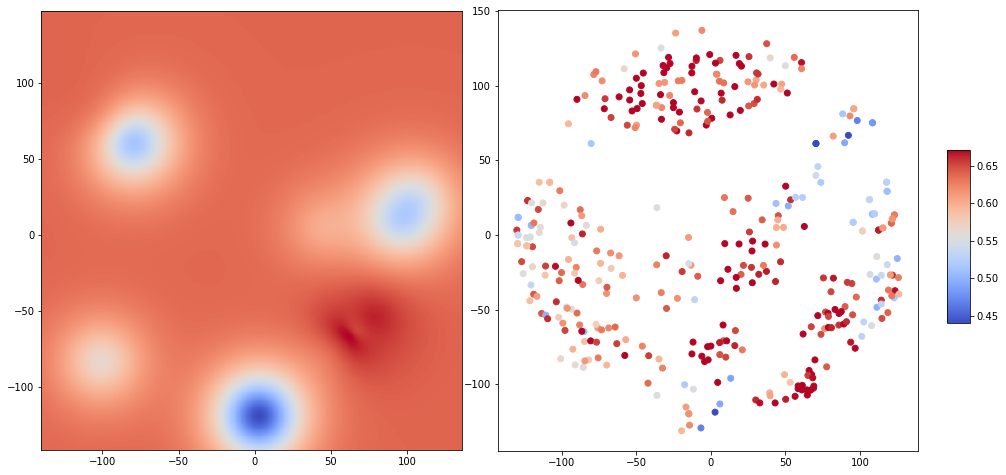

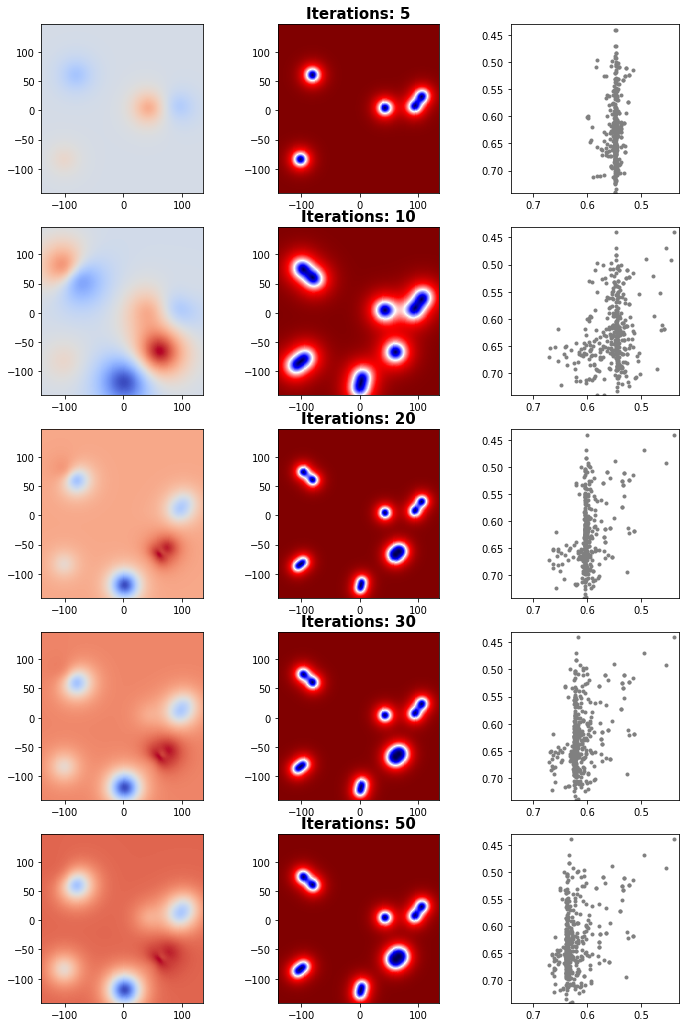

In [10]:
kappa = .1
# path to the raw data
model_config = {}
model_config['data_root'] = data_raw
ClassOrRegression = 'Classification'
corr = compute_active_learning(kappa, model_config, ClassOrRegression)
print(f'Spearman correlation {corr}')

## Repetitions

In [12]:
def calculate_conn(Y, files_id):
    TotalSubjects = len(Y)
    TempResults = []
    pipeline = Data_Run['methods_idx'][TempModelNum][1]
    strategy = Data_Run['methods_idx'][TempModelNum][2]
    derivative = Data_Run['methods_idx'][TempModelNum][0]
    data_path = data_root / 'Outputs' / pipeline / strategy / derivative
    # Load the data for every subject.
    for file_id in files_id:
        subject_path = data_path / f'{file_id}_{derivative}.1D'
        rois = pd.read_csv(subject_path, delimiter='\t')
        TempResults.append(rois.to_numpy())
    # Calculate the correlation using the selected metric
    correlation_measure = ConnectivityMeasure(kind=Data_Run['methods_idx'][TempModelNum][3])
    correlation_matrix = correlation_measure.fit_transform(TempResults)
    lower_diag_n = int(rois.shape[1] * (rois.shape[1] - 1) / 2)
    rois_l = np.zeros((TotalSubjects, lower_diag_n))
    for subject in range(TotalSubjects):
        rois_l[subject, :] = correlation_matrix[subject, :, :][np.triu_indices(rois.shape[1], k=1)]
    return rois_l


In [16]:
# Load data demographics
abide_df = load_abide_demographics(data_root)

# Load the embedding results
with open((output_path / 'embeddings.pckl'), 'rb') as handle:
    embeddings = pickle.load(handle)
# Load the labels for the analysis
with open(output_path / 'abide_space.pckl', 'rb') as handle:
    Data_Run = pickle.load(handle)
# Load indices of the subjects used for train and test
with open((output_path / f'indices_space_train.json'), 'rb') as handle:
    indices = json.load(handle)

# TODO: make this more generalisable. We will use the MDS space
model_embedding = embeddings['MDS']
kappa = 10

train_df = abide_df.iloc[indices['idx_train']]
train_Y = train_df['DX_GROUP']
train_files_id = train_df['FILE_ID']
holdout_df = abide_df.iloc[indices['idx_holdout']]
holdout_y = holdout_df['DX_GROUP']
holdout_files_id = holdout_df['FILE_ID']

ClassOrRegress = 'Classification'
model_config = {}
model_config['Data_Run'] = Data_Run['methods_idx']
model_config['files_id'] = train_df['FILE_ID']
model_config['data_root'] = data_root
model_config['output_path'] = output_path

In [17]:
# Check range of predictions
PredictedAcc = pickle.load(open(str(output_path / "predictedAcc.pckl"), "rb"))
print(f'Max {np.max(PredictedAcc)}')
print(f'Min {np.min(PredictedAcc)}')
print(f'Mean and std {np.mean(PredictedAcc)} and {np.std(PredictedAcc)}')

Max 0.7415321304210193
Min 0.4303577081354859
Mean and std 0.6238722697056029 and 0.061795118764971874


Note the next steps might take a few hours to run.

In [18]:
n_repetitions = 2

BestModelGPSpace = np.zeros(n_repetitions)
BestModelGPSpaceModIndex = np.zeros(n_repetitions)
BestModelEmpirical = np.zeros(n_repetitions)
BestModelEmpiricalModIndex = np.zeros(n_repetitions)
ModelActualAccuracyCorrelation = np.zeros(n_repetitions)
cv_scores = np.zeros(n_repetitions)

for DiffInit in range(n_repetitions):
    print(f'Repetiton #: {DiffInit}')
    # Define settings for the analysis
    kernel, optimizer, utility, init_points, n_iter, pbounds, nbrs, RandomSeed = \
        initialize_bo(model_embedding, kappa, repetitions=True,
                      DiffInit=DiffInit)

    FailedIters = run_bo(optimizer, utility, init_points,
                         n_iter, pbounds, nbrs, RandomSeed,
                         model_embedding, model_config, train_Y,
                         ClassOrRegress,
                         MultivariateUnivariate=True,
                         repetitions=True,
                         verbose=False)
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True,
                                  n_restarts_optimizer=10)

    x_temp = np.array([[res["params"]["b1"]] for res in optimizer.res])
    y_temp = np.array([[res["params"]["b2"]] for res in optimizer.res])
    z_temp = np.array([res["target"] for res in optimizer.res])

    x_obs = x_temp[FailedIters == 0]
    y_obs = y_temp[FailedIters == 0]
    z_obs = z_temp[FailedIters == 0]

    muModEmb, sigmaModEmb, gpModEmb = posteriorOnlyModels(gp, x_obs, y_obs, z_obs,
                                                          model_embedding)

    BestModelGPSpace[DiffInit] = muModEmb.max()
    BestModelGPSpaceModIndex[DiffInit] = muModEmb.argmax()
    BestModelEmpirical[DiffInit] = z_obs.max()
    Model_coord = np.array([[x_obs[z_obs.argmax()][-1], y_obs[z_obs.argmax()][-1]]])
    BestModelEmpiricalModIndex[DiffInit] = nbrs.kneighbors(Model_coord)[1][0][0]
    ModelActualAccuracyCorrelation[DiffInit] = spearmanr(muModEmb, PredictedAcc)[0]
    TempModelNum = muModEmb.argmax()

    train_rois_l = calculate_conn(train_Y, train_files_id)
    holdout_rois_l = calculate_conn(holdout_y, holdout_files_id)

    model = Pipeline([('scaler', StandardScaler()), ('reg', LogisticRegression(penalty='l2', random_state=0))])

    model.fit(train_rois_l, train_Y.ravel())
    pred = model.predict(holdout_rois_l)
    y_proba = model.predict_proba(holdout_rois_l)[:, 1]
    score = roc_auc_score(holdout_y.ravel(), y_proba)

    #CVPValBestModels[DiffInit] = pvalue
    cv_scores[DiffInit] = score

df_best = pd.DataFrame(columns=['repetition', 'pipeline', 'derivatives', 'strategies', 'conn_metrics', 'score'])
for n in range(n_repetitions):
    n_results = {}
    n_results['repetition'] = n
    n_results['pipeline'] = Data_Run['methods_idx'][int(BestModelGPSpaceModIndex[n])][1]
    n_results['derivatives'] = Data_Run['methods_idx'][int(BestModelGPSpaceModIndex[n])][0]
    n_results['strategies'] = Data_Run['methods_idx'][int(BestModelGPSpaceModIndex[n])][2]
    n_results['conn_metrics'] = Data_Run['methods_idx'][int(BestModelGPSpaceModIndex[n])][3]
    n_results['score'] = cv_scores[n]
    df_best = df_best.append(n_results, ignore_index=True)
df_best = df_best.set_index('repetition')
# format the score column to a 3 digits
df_best['score'] = df_best['score'].apply('{:.3f}'.format)


  0%|                                                                                                                                                                                | 0/20 [00:00<?, ?it/s]

Repetiton #: 0


  0%|                                                                                                                                                                                | 0/20 [00:00<?, ?it/s]

Repetiton #: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:29<00:00, 19.47s/it]


In [ ]:
df_best

In [ ]:
# save the results
repetions_results = {
    'dataframe': df_best,
    'BestModelGPSpaceModIndex': BestModelGPSpaceModIndex,
    'BestModelEmpiricalIndex': BestModelEmpiricalModIndex,
    'BestModelEmpirical': BestModelEmpirical,
    'ModelActualAccuracyCorrelation': ModelActualAccuracyCorrelation
}
pickle.dump(repetions_results, open(str(output_path / "repetitions_results.p"), "wb"))